In [ ]:
# This Code for image classification 
# and see the blackbox of the deep-learning model 
# XAI, Lime

In [55]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [37]:
# Data Reading

with open('./shipsnet.json') as f:
  df_dict = json.load(f)

df = pd.DataFrame(df_dict)
df.head()

,data,labels,locations,scene_ids
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1,"[-118.2254694333423, 33.73803725920789]",20180708_180909_0f47
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1,"[-122.33222866289329, 37.7491755586813]",20170705_180816_103e
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1,"[-118.14283073363218, 33.736016066914175]",20180712_211331_0f06
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1,"[-122.34784341495181, 37.76648707436548]",20170609_180756_103a
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1,"[-122.34852408322172, 37.75878462398653]",20170515_180653_1007


In [38]:
# to make Image Classification model, we need ['data'] and ['labels']

df = df[['data', 'labels']]

# to recognize how many pixels and channels
# 19200 / 3 channels = 6400 -> 80 x 80 pixels

len(df['data'].iloc[0])

19200

In [39]:
# to check how many labels are there
# twe(2) category labels without NaN

df['labels'].value_counts(dropna = False)

0    3000
1    1000
Name: labels, dtype: int64

In [79]:
# to separate ['data'] adn ['labels']
# the 'x' needs to be reshaped to 80 x 80 pixels with 3channel imanges
# the 'x' should be nomalized by divided 255, ifnot the model not to works well

x = np.array(df_dict['data'])
y = np.array(df_dict['labels'])

x_reshaped = x.reshape([-1, 3, 80, 80]).transpose([0, 2, 3, 1]) / 255

print(x_reshaped.shape, y.shape)

(4000, 80, 80, 3) (4000,)


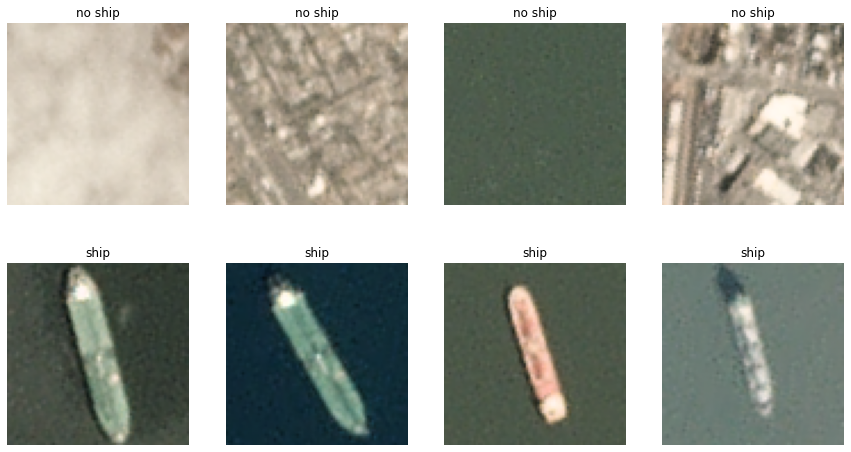

In [80]:
# let's see the images of ships(label = 1) and no-ships(label = 0)

image_ship = x_reshaped[y==1]
image_no_ship = x_reshaped[y==0]

def plot(a, b):
    plt.figure(figsize=(15,15))
    
    for i, k in enumerate(range(1, 9)):
        if i <4:
            plt.subplot(2, 4, k)
            plt.title('no ship')
            plt.imshow(image_no_ship[i+2])
            plt.axis('off')
        else:
            plt.subplot(2, 4, k)
            plt.title('ship')
            plt.imshow(image_ship[i+15])
            plt.axis('off')
            
    plt.subplots_adjust(bottom = 0.3, top = 0.7, hspace = 0.25)
    
plot(image_no_ship, image_ship)

In [81]:
# the target 'y' needs to be categorical
# because the model to use categorical_crossentropy as loss function

y = to_categorical(y)
print(y.shape)

(4000, 2)


In [87]:
# modeling

model = Sequential()
model.add(layers.Conv2D(128, kernel_size = 3, activation = 'relu', input_shape=(80, 80, 3)))
model.add(layers.MaxPooling2D(2))
model.add(layers.Conv2D(64, kernel_size = 3, activation = 'relu'))
model.add(layers.MaxPooling2D(2))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(2, activation = 'sigmoid'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 78, 78, 128)       3584      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 39, 39, 128)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 37, 37, 64)        73792     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 18, 18, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 20736)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)                663584    
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)               

In [88]:
# Training

x_train, x_test, y_train, y_test = train_test_split(x_reshaped, y, test_size = 0.3)

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

modelpath = './best_model.hd5'
checkpoint = callbacks.ModelCheckpoint(filepath = modelpath, monitor = 'val_loss', verbose = 0, save_best_only = True)
early = callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

history = model.fit(x_train, y_train, epochs = 50, validation_split = 0.3, verbose = 1, callbacks = [checkpoint, early])

Train on 1959 samples, validate on 841 samples
Epoch 1/50
1959/1959 [==============================] - 31s 16ms/sample - loss: 0.4387 - accuracy: 0.8081 - val_loss: 0.2535 - val_accuracy: 0.9001
Epoch 2/50
1959/1959 [==============================] - 20s 10ms/sample - loss: 0.2710 - accuracy: 0.8760 - val_loss: 0.1823 - val_accuracy: 0.9287
Epoch 3/50
1959/1959 [==============================] - 18s 9ms/sample - loss: 0.2404 - accuracy: 0.8811 - val_loss: 0.1955 - val_accuracy: 0.9287
Epoch 4/50
1959/1959 [==============================] - 19s 10ms/sample - loss: 0.2304 - accuracy: 0.8867 - val_loss: 0.1627 - val_accuracy: 0.9322
Epoch 5/50
1959/1959 [==============================] - 19s 10ms/sample - loss: 0.2096 - accuracy: 0.8851 - val_loss: 0.2384 - val_accuracy: 0.9275
Epoch 6/50
1959/1959 [==============================] - 19s 10ms/sample - loss: 0.1883 - accuracy: 0.9275 - val_loss: 0.2012 - val_accuracy: 0.9251
Epoch 7/50
1959/1959 [==============================] - 19s 10ms/s

In [89]:
model.evaluate(x_test, y_test)

1200/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.08448062509298325, 0.9791667]

In [101]:
# print incorrect index

incorrect_idx = []

for i in range(len(x_reshaped)):
  if df['labels'][i] != np.argmax(model.predict(x_reshaped[i].reshape(-1,80,80,3))):
    incorrect_idx.append(i)

incorrect_idx

[23,
 75,
 83,
 190,
 240,
 278,
 334,
 369,
 379,
 424,
 441,
 467,
 530,
 532,
 538,
 545,
 562,
 609,
 636,
 665,
 670,
 682,
 692,
 749,
 758,
 816,
 824,
 833,
 844,
 877,
 902,
 930,
 953,
 973,
 2018,
 2034,
 2051,
 2746,
 2761,
 3008,
 3049,
 3097,
 3100,
 3121,
 3216,
 3226,
 3340,
 3394,
 3451,
 3482,
 3488,
 3558,
 3681,
 3693,
 3695,
 3697,
 3817,
 3851,
 3892,
 3918,
 3922,
 3925,
 3980,
 3987]

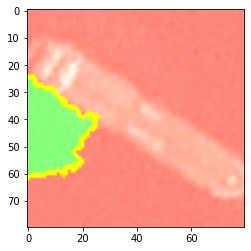

In [102]:
# XAI, Lime

from lime import lime_image
from skimage.segmentation import mark_boundaries

idx = 23

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(x_reshaped[idx], model.predict)

plt.imshow(x_reshaped[idx])
image, mask = explanation.get_image_and_mask(
    model.predict(x_reshaped[idx].reshape(-1, 80, 80, 3)).argmax(axis = 1)[0],
    positive_only = False,
    hide_rest = False
)

plt.imshow(mark_boundaries(image,mask))

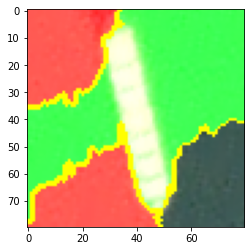

In [110]:
idx = 25

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(x_reshaped[idx], model.predict)

plt.imshow(x_reshaped[idx])
image, mask = explanation.get_image_and_mask(
    model.predict(x_reshaped[idx].reshape(-1, 80, 80, 3)).argmax(axis = 1)[0],
    positive_only = False,
    hide_rest = False
)

plt.imshow(mark_boundaries(image,mask))

In [ ]:
# refer to the 'lime',
# it seems to depend on the 'edge' of the 'bow'
# if the model catches the edgd of the bow parts, the answer is correct.